# WebScraping with Selenium

This notebook shows how use selenium to scrape data from an Pagine Gialle web site.
The scope is only to understand the capabilities of web scraping and prepare a dataset for academic purporse.

Let’s begin writing our scraper!

We will first install important modules and packages for our Notebook


*   Selenium
*   Chromium-chromedriver



In [1]:
!pip install selenium
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

     |████████████████████████████████| 911kB 5.9MB/s 
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease

And now we will import some modules on our Notebook


1.   sys: to setup the path of chrome driver
2.   selenium: to emulate the user behaviour
3.   pandas: to work with data
4.   tqdm: to show a progress bar in our notebook
5.   json: to work with json format





In [2]:
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
from tqdm import tqdm_notebook as tqdm
import pandas
import json
import pprint

First we need to set the options for the ghost browser.
The most important is `--headless` because we are in a "cloud" notebook. In our local notebook we can remove the `--headless` option.  


In [3]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument("window-size=1900,800")
chrome_options.add_argument("--enable-javascript")
chrome_options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.150 Safari/537.36")

`webdriver` is the most importa object in Selenium.
With `webdriver` we can start the phantom browser, emulate the user navigation and scrape our data. 

Let’s now create a new instance of google chrome.


We will navitage to page by a `get` request. With http we can do a get or a post (or others but they are not important for us): https://www.w3schools.com/tags/ref_httpmethods.asp 



```
wd.get("https://www.paginegialle.it/ricerca/ceramica")
```



In [15]:
wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
wd.get("https://www.paginegialle.it/ricerca/ceramica")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: use options instead of chrome_options
  """Entry point for launching an IPython kernel.


Take a look to the screenshot from our phantom browser.

Note:
- la language and the locale: It is en_US!
- the screen ration: is it the same of our notebook?

Populating the interactive namespace from numpy and matplotlib


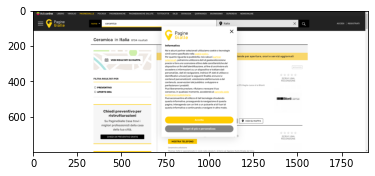

In [5]:
wd.save_screenshot('screenshot.png')

%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('/content/screenshot.png')
imgplot = plt.imshow(img)
plt.show()

Click on cookie accept button

In [6]:
wd.find_elements_by_css_selector("button.iubenda-cs-customize-btn")[0].click()

Let's try to extract some information from the page



`title` contains the title of our page.




In [7]:
print(wd.title)

Ceramica | PagineGialle.it


### How do we extract the values inside a page with CSS Selector?

Selenium has a method called `find_elements_by_css_selector`.

We will pass our CSS Selector into this method and get a list of selenium elements. Once we have the element, we can extract the text inside it using the `text` function.

In [8]:
list_companies = wd.find_elements_by_css_selector("h2.itemTitle")
print(len(list_companies))

20


In [9]:
print(list_companies[0].text)

BITONTI CERAMICHE LA CERAMICA


# Extract the companies list

Let's begin to download the list of companies.

The list of companies is defined by the css selection rule
`section.vcard`



In [10]:
list_companies = wd.find_elements_by_css_selector("section.vcard")
print(len(list_companies))

20


Gread! We find 10 items!

Now, we will extract the attribute from each single element.
The scope is to create one dict for each item in the list with the attribute:


1.   company name
2.   link to the detail page
3.   number of employees
4.   vat code
5.   economic sector
6.   tags



In [11]:
import pprint
import time
items = []
for item in list_companies:
    company_name = item.find_elements_by_css_selector("h2.itemTitle")[0].text
    url = item.find_elements_by_css_selector("a.icn-vetrina")[0].get_attribute("href")

    items.append({'company_name': company_name,
                  'url': url})


pprint.pprint(items[0:5])

[{'company_name': 'BITONTI CERAMICHE LA CERAMICA',
  'url': 'https://www.paginegialle.it/laceramicabitonti'},
 {'company_name': 'THOMAS HOFER',
  'url': 'https://www.paginegialle.it/hoferthomas'},
 {'company_name': 'SIL.MAR CERAMICHE',
  'url': 'https://www.paginegialle.it/silmarceramiche-vr'},
 {'company_name': 'CINI ARREDO BAGNO',
  'url': 'https://www.paginegialle.it/ciniromano'},
 {'company_name': 'C.E.P.I.R. SOC. COOP.',
  'url': 'https://www.paginegialle.it/cepir'}]


Get the list of the first 100 companies

In [12]:
import math
wd.get("https://www.paginegialle.it/ricerca/ceramica/Italia/p-1")
total_items = wd.find_elements_by_css_selector('span.searchResNum span')[0].text
page_total = math.ceil(int(total_items) / 20)
print(page_total)

407


In [16]:
items = []
for page in range(1, 16):
  wd.get(f"https://www.paginegialle.it/ricerca/ceramica/Italia/p-{page}")
  time.sleep(1)
  list_companies = wd.find_elements_by_css_selector("section.vcard")
  for item in list_companies:
    company_name = item.find_elements_by_css_selector("h2.itemTitle")[0].text
    url = item.find_elements_by_css_selector("a.icn-vetrina")[0].get_attribute("href")
    items.append({'company_name': company_name,
                  'url': url})

Check the list returned by our scraper:

In [17]:
len(items)

300

In [18]:
pprint.pprint(items[90:95])

[{'company_name': 'MARTINELLI LEOPOLDO',
  'url': 'https://www.paginegialle.it/martinellileopoldosrl'},
 {'company_name': 'CERAMICHE GARUTI',
  'url': 'https://www.paginegialle.it/ceramichegaruti'},
 {'company_name': 'NUOVA O.M.C.',
  'url': 'https://www.paginegialle.it/nuovaomcattrezzatureceramiche'},
 {'company_name': 'CERAMICHE DELLA MADDALENA LINO',
  'url': 'https://www.paginegialle.it/dellamaddalenalino'},
 {'company_name': 'NUOVA SIMA SPA',
  'url': 'https://www.paginegialle.it/nuovasimaspa'}]


Navigate to each detail page and get the details

In [20]:
details = []
for item in tqdm(items):
  wd.get(item['url'])
  # print(item['url'])
  time.sleep(1)

  description = wd.find_elements_by_css_selector("#descrizioneAzienda")[0].text
  abstract = ""
  try:
    abstract = wd.find_elements_by_css_selector("h2.dsabstract")[0].text
  except:
    abstract = ""
  wd.find_elements_by_css_selector('.btn-show-phone')[0].click()
  phone = wd.find_elements_by_css_selector('span.tel')[0].text
  url = ""
  try:
    url = wd.find_elements_by_css_selector("a.icn-sitoWeb")[0].get_attribute("href")
  except:
    url = item['url']
  address = wd.find_elements_by_css_selector('div.street-address')[0].text
  altre_informazioni = wd.find_elements_by_css_selector("section.altre-info-azienda div")
  vat_code = ""
  for box in altre_informazioni:
    if 'Partita IVA' in box.text:
      vat_code = box.find_elements_by_css_selector("span")[0].text
  company_name = item['company_name']
  
  details.append({'company_name': company_name,
                  'address': address,
                  'phone': phone,
                  'description': description,
                  'vat_code': vat_code,
                  'abstract': abstract,
                  'url': url})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [21]:
pprint.pprint(details[0:5])

[{'abstract': 'Forniamo ad artigiani e privati un vasto assortimento di '
              'accessori e mobili da bagno, ceramiche, piastrelle per '
              'pavimenti e rivestimenti a Bibbiena.',
  'address': 'Via San Francesco Loc Partina - 52011 Bibbiena (AR)',
  'company_name': 'EDIL CASA',
  'description': 'La nostra azienda, a conduzione familiare, dal 1980 è in '
                 'grado di fornire a privati ed artigiani una vasta scelta di '
                 'prodotti per la rifinizione e arredamento della casa. '
                 'Accessori e mobili da bagno, ceramiche e piastrelle per '
                 'pavimenti e rivestimenti, rubinetterie ed accessori, '
                 'caminetti e stufe... Vi aspettiamo perché siamo in grado, '
                 'con disponibilità e cortesia, di rispondere ad ogni tipo di '
                 'richiesta.',
  'phone': '0575 560321',
  'url': 'https://www.edilcasapavimentirivestimenticaminetti.com/',
  'vat_code': '01162210510'},
 {'abstr

# Pandas and data processing

**Well!**
We're starting to see another amazing library for working with data!

It's **pandas**: *Python library for data analysis*.

Basically, with pandas we can manipulate a data set or a historical series in Python.

For now, we start to give a couple of concepts.

Pandas is based on two types of data: **Series** and **DataFrame**:
- `Series` represents a list of data
- `DataFrame` represent a data set in tabular format

Each column of a `DataFrame` is a `Series`.

We can create a `DataFrame` using the `pd.DataFrame` method by passing our dictionary as an input parameter.

A `DataFrame` pandas can be easily exported in *CSV*, *Excel*, ...

For more information about `Pandas` see

https://pandas.pydata.org/getting_started.html


In [22]:
import pandas as pd
ds_items = pd.DataFrame(details)
ds_items.set_index("vat_code")
ds_items.head()

,company_name,address,phone,description,vat_code,abstract,url
0,EDIL CASA,Via San Francesco Loc Partina - 52011 Bibbiena...,0575 560321,"La nostra azienda, a conduzione familiare, dal...",01162210510,Forniamo ad artigiani e privati un vasto assor...,https://www.edilcasapavimentirivestimenticamin...
1,THOMAS HOFER,"Strada S. Antonio, 23/B - 39057 Appiano sulla ...",335 7591738,La stufa in maiolica è l'unico mezzo di riscal...,01420450213,Thomas Hofer è specializzato in stufe nella st...,http://www.kachelofen-hofer.com/
2,SIL.MAR CERAMICHE,"Via Masero, 14 - 37040 Roveredo di Guà (VR)",0442 86229,"Una giovane azienda operante nel settore, spec...",03925200234,"Sil.Mar prodotti per il bagno, dagli idrosanit...",https://www.paginegialle.it/silmarceramiche-vr
3,CINI ARREDO BAGNO,"Dorsoduro, 3108 - 30123 Venezia (VE)",041 5235317,Fondata nel 1988 a Venezia da Romano Cini come...,02263160273,A Venezia si trova Cini Arredo Bagno specializ...,https://www.ciniarredobagno.it/
4,C.E.P.I.R. SOC. COOP.,"Via Mazzoni, 16/B - 40011 Anzola dell'Emilia (BO)",051 733988,Il consorzio C.E.P.I.R. certificato ISO 9001:2...,04333610378,Il consorzio C.E.P.I.R. si occupa di fornire e...,http://www.cepirscrl.com/?page_id=11


In [ ]:
ds_items.info()

In [24]:
ds_items.to_csv('ds_items.csv')